# Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import boxcox
from scipy.stats import pearsonr

# Load Dataset

In [2]:
# Load dataset
file_path_tr = "/kaggle/input/mic-dcgr/MIC_DCGR_TR.csv"
file_path_ts = "/kaggle/input/mic-dcgr/MIC_DCGR_TS.csv"

df = pd.read_csv(file_path_tr)
df_MIC_Ts = pd.read_csv(file_path_ts)

<ipython-input-2-cb7f4a5ef03c>:5: DtypeWarning: Columns (632) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path_tr)


In [121]:
# 11266,633
# 2253,632
file_path_tar = "/kaggle/input/mic-dcgr/Y.csv"
df_MIC_Tr = pd.read_csv(file_path_tar)
df.shape

(11266, 633)

**Check if NaN**

In [143]:
# print(df.isna().any().any())
# print(df.isna().sum())
# print(df[df.isna().any(axis=1)]) 
# df["MIC"] = pd.to_numeric(df["MIC"], errors='coerce')
df['MIC'].isna().any()

False

In [148]:
# Convert TARGET column to numeric

df["MIC"] = pd.to_numeric(df["MIC"], errors='coerce')

# Drop rows with NaN values in TARGET
df_cleaned = df.dropna(subset=["MIC"])

# Apply Box-Cox Transformation to TARGET (best transformation found)
df_cleaned["TARGET_BOXCOX"], lambda_value = boxcox(df_cleaned["MIC"] + 1)  # Adding 1 to handle zeros

# Selecting Box-Cox transformed target
df_cleaned["TARGET_TRANSFORMED"] = df_cleaned["TARGET_BOXCOX"]

# Dropping unneeded columns
df_cleaned = df_cleaned.drop(columns=["MIC"])

# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Normalize feature columns
features = df_cleaned.drop(columns=["TARGET_TRANSFORMED"])
features_normalized = pd.DataFrame(scaler.fit_transform(features), columns=features.columns)

# Normalize the transformed target variable
target_normalized = scaler.fit_transform(df_cleaned["TARGET_TRANSFORMED"].values.reshape(-1, 1))

# Creating final normalized dataset
df_normalized = features_normalized.copy()
df_normalized["TARGET_NORMALIZED"] = target_normalized

# Save the normalized dataset (Optional)
df_normalized.to_csv("Normalized_Data.csv", index=False)

# Print confirmation
print("Min-Max Normalization applied successfully! Normalized dataset saved as 'Normalized_Data.csv'.")

# Display first few rows
print(df_normalized.head())

<ipython-input-148-9f292abe84f5>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned["TARGET_BOXCOX"], lambda_value = boxcox(df_cleaned["MIC"] + 1)  # Adding 1 to handle zeros
<ipython-input-148-9f292abe84f5>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned["TARGET_TRANSFORMED"] = df_cleaned["TARGET_BOXCOX"]


Min-Max Normalization applied successfully! Normalized dataset saved as 'Normalized_Data.csv'.
     DCGR_1    DCGR_2    DCGR_3    DCGR_4    DCGR_5    DCGR_6    DCGR_7  \
0  0.403656  0.508723  0.492163  0.233512  0.110190  0.000000  0.000000   
1  0.204393  0.178467  0.058236  0.096718  0.238783  0.212739  0.234077   
2  0.049671  0.096052  0.227521  0.037027  0.032275  0.156560  0.107316   
3  0.184254  0.098997  0.239274  0.058649  0.201646  0.138244  0.154850   
4  0.400460  0.424812  0.178128  0.556582  0.452729  0.112066  0.117283   

     DCGR_8    DCGR_9   DCGR_10  ...  DCGR_625  DCGR_626  DCGR_627  DCGR_628  \
0  0.346797  0.012404  0.026234  ...  0.000000  0.000000  0.126723  0.105915   
1  0.199081  0.319265  0.116280  ...  0.185446  0.361191  0.230402  0.177777   
2  0.109253  0.297854  0.142428  ...  0.232061  0.279959  0.397680  0.468461   
3  0.044511  0.057393  0.236451  ...  0.261786  0.332870  0.263893  0.403214   
4  0.068243  0.059057  0.000000  ...  0.128327  0.5173

In [150]:
df_normalized.shape

(7915, 634)

# With Normailization

In [151]:
X = df_normalized.drop(columns=["TARGET_NORMALIZED"])
y = df_normalized["TARGET_NORMALIZED"]

# Without Normailization

In [6]:
# Convert TARGET column to numeric
df["MIC"] = pd.to_numeric(df["MIC"], errors="coerce")

# Drop rows with missing TARGET values
df = df.dropna(subset=["MIC"])

# Define features and target
X = df.drop(columns=["MIC"])
y = df["MIC"]

In [152]:
# Split into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [153]:
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
    "Support Vector Regressor": SVR()
}

In [154]:
# Train models and evaluate performance
results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Calculate evaluation metrics
    correlation = np.corrcoef(y_test, y_pred)[0, 1]
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    results.append([name, correlation, mae, rmse, r2])


# Fine-tune the Random Forest model

In [155]:
# Create results dataframe
results_df = pd.DataFrame(results, columns=["Model", "Correlation", "MAE", "RMSE", "R² Score"])

# Display results
print(results_df)

                      Model  Correlation           MAE          RMSE  R² Score
0         Linear Regression     1.000000  9.465082e-16  1.217568e-15  1.000000
1             Random Forest     0.999999  1.918913e-04  3.728896e-04  0.999997
2         Gradient Boosting     0.999975  1.090627e-03  1.615424e-03  0.999950
3  Support Vector Regressor     0.979946  4.986312e-02  6.296589e-02  0.924325


In [156]:
# Manually fine-tuned Random Forest parameters
optimized_rf = RandomForestRegressor(
    n_estimators=200,  # Increased trees for better performance
    max_depth=20,  # Limiting depth to avoid overfitting
    min_samples_split=2,  # Default split condition
    min_samples_leaf=1,  # Minimum samples per leaf node
    max_features='sqrt',  # Consider sqrt of features at each split
    random_state=42,
    n_jobs=-1
)

In [157]:
optimized_rf.fit(X_train, y_train)

# Predict on test set
y_pred_optimized = optimized_rf.predict(X_test)

# Calculate evaluation metrics
correlation_optimized = np.corrcoef(y_test, y_pred_optimized)[0, 1]
mae_optimized = mean_absolute_error(y_test, y_pred_optimized)
rmse_optimized = np.sqrt(mean_squared_error(y_test, y_pred_optimized))
r2_optimized = r2_score(y_test, y_pred_optimized)

# Display results
optimized_results = pd.DataFrame([["Optimized Random Forest", correlation_optimized, mae_optimized, rmse_optimized, r2_optimized]], 
                                 columns=["Model", "Correlation", "MAE", "RMSE", "R² Score"])

print(optimized_results)

                     Model  Correlation       MAE      RMSE  R² Score
0  Optimized Random Forest     0.888707  0.080905  0.109198  0.772402


# New Samples Testing

In [ ]:
df_MIC_Ts.shape
df_MIC_Ts=df_MIC_Ts.dropna()
target_normalized = scaler.fit_transform(df_MIC_Ts)
y_test_new=target_normalized

In [77]:
X_test.iloc[0].shape

(633,)

In [80]:
X_test.iloc[0].values.reshape(1, -1).shape

(1, 633)

In [82]:
# Predict on test set
y_pred_optimized = optimized_rf.predict(X_test.iloc[0].values.reshape(1, -1))
y_pred_optimized

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


array([0.36608056])

**Experiment2**

In [13]:
# Load datasets
file_path_tr = "/kaggle/input/mic-dcgr/MIC_DCGR_TR.csv"  # Training set (with 'MIC')
file_path_ts = "/kaggle/input/mic-dcgr/MIC_DCGR_TS.csv"  # Test set (without 'MIC')
df_train = pd.read_csv(file_path_tr)
df_test = pd.read_csv(file_path_ts)  # No 'MIC' column

<ipython-input-13-e26b04f43196>:4: DtypeWarning: Columns (632) have mixed types. Specify dtype option on import or set low_memory=False.
  df_train = pd.read_csv(file_path_tr)


In [14]:
df_train.columns

Index(['DCGR_1', 'DCGR_2', 'DCGR_3', 'DCGR_4', 'DCGR_5', 'DCGR_6', 'DCGR_7',
       'DCGR_8', 'DCGR_9', 'DCGR_10',
       ...
       'DCGR_624', 'DCGR_625', 'DCGR_626', 'DCGR_627', 'DCGR_628', 'DCGR_629',
       'DCGR_630', 'DCGR_631', 'DCGR_632', 'MIC'],
      dtype='object', length=633)

In [ ]:
# Convert TARGET column ('MIC') to numeric in training set
df_train["MIC"] = pd.to_numeric(df_train["MIC"], errors='coerce')


# Drop rows with NaN values in 'MIC' (target variable)
df_train = df_train.dropna(subset=["MIC"])

# Apply Box-Cox 

In [ ]:
Transformation to 'MIC' (best transformation found)
df_train["TARGET_BOXCOX"], lambda_value = boxcox(df_train["MIC"] + 1)  # Adding 1 to handle zeros

# Selecting Box-Cox transformed target
df_train["TARGET_TRANSFORMED"] = df_train["TARGET_BOXCOX"]

# Dropping original target variable from training data
df_train = df_train.drop(columns=["MIC", "TARGET_BOXCOX"])

# Split training data into training and validation sets (80% train, 20% validation)
X = df_train.drop(columns=["TARGET_TRANSFORMED"])  # Features from training set
y = df_train["TARGET_TRANSFORMED"]  # Target variable from training set
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Normalize training and validation features
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_val_scaled = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)

# Normalize the target variable
y_train_scaled = scaler.fit_transform(y_train.values.reshape(-1, 1))
y_val_scaled = scaler.transform(y_val.values.reshape(-1, 1))

In [17]:
# Train Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train_scaled.ravel())  # .ravel() to avoid warnings

# Predict on validation set
y_val_pred = rf_model.predict(X_val_scaled)


In [18]:
from scipy.stats import pearsonr, spearmanr

# Evaluate Model on Validation Set
def evaluate_model(y_true, y_pred, dataset_name):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    # Pearson Correlation (Measures linear correlation)
    pearson_corr, _ = pearsonr(y_true.flatten(), y_pred.flatten())
    
    # Spearman Correlation (Measures monotonic relationship)
    spearman_corr, _ = spearmanr(y_true.flatten(), y_pred.flatten())

    print(f"Model Performance on {dataset_name}:")
    print(f"  - MAE: {mae:.4f}")
    print(f"  - MSE: {mse:.4f}")
    print(f"  - R² Score: {r2:.4f}")
    print(f"  - Pearson Correlation: {pearson_corr:.4f}")
    print(f"  - Spearman Correlation: {spearman_corr:.4f}")
    print("-" * 50)

# Display validation performance with correlation
evaluate_model(y_val_scaled, y_val_pred, "Validation Set")


Model Performance on Validation Set:
  - MAE: 0.1273
  - MSE: 0.0269
  - R² Score: 0.4873
  - Pearson Correlation: 0.6999
  - Spearman Correlation: 0.6791
--------------------------------------------------


In [19]:
# Manually fine-tuned Random Forest parameters
optimized_rf = RandomForestRegressor(
    n_estimators=200,  # Increased trees for better performance
    max_depth=20,  # Limiting depth to avoid overfitting
    min_samples_split=2,  # Default split condition
    min_samples_leaf=1,  # Minimum samples per leaf node
    max_features='sqrt',  # Consider sqrt of features at each split
    random_state=42,
    n_jobs=-1
)

In [20]:
# Train the model on scaled training data
optimized_rf.fit(X_train_scaled, y_train_scaled.ravel())

# Predict on validation set
y_val_pred_optimized = optimized_rf.predict(X_val_scaled)

# Evaluate on Validation Set
def evaluate_model(y_true, y_pred, dataset_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    pearson_corr, _ = pearsonr(y_true.flatten(), y_pred.flatten())
    spearman_corr, _ = spearmanr(y_true.flatten(), y_pred.flatten())

    print(f"Model Performance on {dataset_name}:")
    print(f"  - MAE: {mae:.4f}")
    print(f"  - RMSE: {rmse:.4f}")
    print(f"  - R² Score: {r2:.4f}")
    print(f"  - Pearson Correlation: {pearson_corr:.4f}")
    print(f"  - Spearman Correlation: {spearman_corr:.4f}")
    print("-" * 50)

# Display validation performance
evaluate_model(y_val_scaled, y_val_pred_optimized, "Validation Set")

Model Performance on Validation Set:
  - MAE: 0.1271
  - RMSE: 0.1637
  - R² Score: 0.4892
  - Pearson Correlation: 0.7009
  - Spearman Correlation: 0.6802
--------------------------------------------------


**Train & Validate Different Regressors**

In [30]:
# Function to Train & Evaluate Models
def train_and_evaluate(model, model_name):
    # Train model
    model.fit(X_train_scaled, y_train_scaled.ravel())

    # Predict on validation set
    y_val_pred = model.predict(X_val_scaled)

    # Evaluate model
    mae = mean_absolute_error(y_val_scaled, y_val_pred)
    rmse = np.sqrt(mean_squared_error(y_val_scaled, y_val_pred))
    r2 = r2_score(y_val_scaled, y_val_pred)
    pearson_corr, _ = pearsonr(y_val_scaled.flatten(), y_val_pred.flatten())

    print(f"📌 Performance of {model_name}:")
    print(f"  - MAE: {mae:.4f}")
    print(f"  - RMSE: {rmse:.4f}")
    print(f"  - R² Score: {r2:.4f}")
    print(f"  - Pearson Correlation: {pearson_corr:.4f}")
    print("-" * 50)

# Initialize Models
linear_reg = LinearRegression()
gradient_boost = GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, max_depth=5, random_state=42)
svr = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.1)

# Train and Evaluate Each Model
train_and_evaluate(linear_reg, "Linear Regression")
train_and_evaluate(gradient_boost, "Gradient Boosting")
train_and_evaluate(svr, "Support Vector Regression")

📌 Performance of Linear Regression:
  - MAE: 0.1555
  - RMSE: 0.1913
  - R² Score: 0.3029
  - Pearson Correlation: 0.5627
--------------------------------------------------
📌 Performance of Gradient Boosting:
  - MAE: 0.1269
  - RMSE: 0.1634
  - R² Score: 0.4917
  - Pearson Correlation: 0.7036
--------------------------------------------------
📌 Performance of Support Vector Regression:
  - MAE: 0.1290
  - RMSE: 0.1645
  - R² Score: 0.4845
  - Pearson Correlation: 0.6989
--------------------------------------------------


In [22]:
# Load the independent test dataset (without target variable)
file_path_ts = "/kaggle/input/mic-dcgr/MIC_DCGR_TS.csv"
df_test = pd.read_csv(file_path_ts)  # No 'MIC' column

# Ensure test features have the same columns as training set
df_test.columns = X_train.columns 

if set(df_test.columns) != set(X_train.columns):
    raise ValueError("Mismatch in feature columns between train and test sets!")

scaler = MinMaxScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_val_scaled = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)

# Normalize the independent test set using the same scaler
X_test_scaled = pd.DataFrame(scaler.transform(df_test), columns=X_train.columns)  # Use same feature names

print(f"Test set scaled successfully! Shape: {X_test_scaled.shape}")
# Predict on the independent test set
y_test_pred = rf_model.predict(X_test_scaled)

# Save Predictions for Test Set
df_test_predictions = pd.DataFrame(y_test_pred, columns=["Predicted_MIC"])
df_test_predictions.to_csv("Test_Set_Predictions.csv", index=False)

print("Predictions on the independent test set are saved as 'Test_Set_Predictions.csv'. 🚀")


Test set scaled successfully! Shape: (2252, 632)
Predictions on the independent test set are saved as 'Test_Set_Predictions.csv'. 🚀


**Visualize Distribution of Predictions**

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


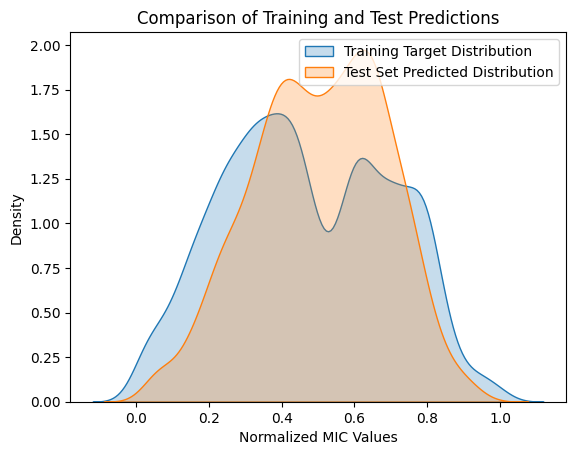

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot distributions of predicted MIC values
sns.kdeplot(y_train_scaled.ravel(), label="Training Target Distribution", fill=True)
sns.kdeplot(y_test_pred, label="Test Set Predicted Distribution", fill=True)

plt.title("Comparison of Training and Test Predictions")
plt.xlabel("Normalized MIC Values")
plt.ylabel("Density")
plt.legend()
plt.show()


In [28]:
std_dev_test_predictions = np.std(y_test_pred)
print(f"Standard Deviation of Test Predictions: {std_dev_test_predictions:.4f}")

Standard Deviation of Test Predictions: 0.1825


**Use Uncertainty Estimation with Multiple Random Forests**

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


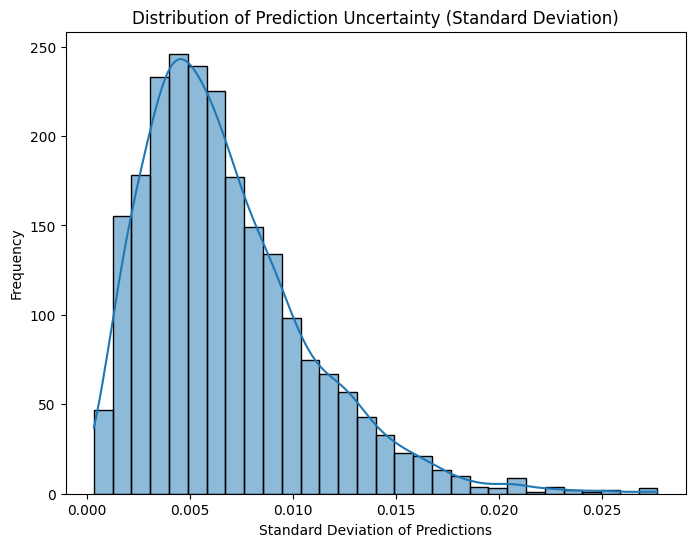

In [29]:
from sklearn.ensemble import RandomForestRegressor

# Train multiple models with different seeds
models = []
num_models = 5
for seed in range(num_models):
    rf = RandomForestRegressor(n_estimators=200, max_depth=20, random_state=seed)
    rf.fit(X_train_scaled, y_train_scaled.ravel())
    models.append(rf)

# Get predictions from each model
predictions = np.array([model.predict(X_test_scaled) for model in models])

# Compute standard deviation of predictions
prediction_std = np.std(predictions, axis=0)

# Plot uncertainty
plt.figure(figsize=(8,6))
sns.histplot(prediction_std, bins=30, kde=True)
plt.title("Distribution of Prediction Uncertainty (Standard Deviation)")
plt.xlabel("Standard Deviation of Predictions")
plt.ylabel("Frequency")
plt.show()


# **Experiment3** **Dataload**

In [2]:
# Load the feature set from train, test and validation.
# file_path_tr = "/kaggle/input/tpc-mic/MIC_TR_TPC.csv"  #training features
# df_train = pd.read_csv(file_path_tr)
# file_path_ts = "/kaggle/input/tpc-mic/MIC_TS_TPC.csv"  #testing features
# df_test = pd.read_csv(file_path_ts)
# file_path_val = "/kaggle/input/tpc-mic/MIC_Val_TPC.csv" #validation features
# df_val = pd.read_csv(file_path_val)

# Load the feature set from train, test and validation.
file_path_tr_mic = "/kaggle/input/target/training_set_cleaned.csv"  #training mic
df_train_mic = pd.read_csv(file_path_tr_mic)
file_path_ts_mic = "/kaggle/input/target/test_set_cleaned.csv"  #testing mic
df_test_mic = pd.read_csv(file_path_ts_mic)
file_path_val_mic = "/kaggle/input/target/validation_test_set_cleaned.csv" #validation mic
df_val_mic = pd.read_csv(file_path_val_mic)
print('okay')

okay


**Multiple feature**

In [3]:
# Load the feature set CTD from train, test and validation.
file_path_tr = "/kaggle/input/ctd-mic/MIC_TR_CTD.csv"  #training features
df_train_CTD = pd.read_csv(file_path_tr)
file_path_ts = "/kaggle/input/ctd-mic/MIC_TS_CTD.csv"  #testing features
df_test_CTD = pd.read_csv(file_path_ts)
file_path_val = "/kaggle/input/ctd-mic/MIC_Val_CTD.csv" #validation features
df_val_CTD = pd.read_csv(file_path_val)

# Load the feature set FEGS from train, test and validation.
file_path_tr = "/kaggle/input/mic-fegs/MIC_FEGS_TR.csv"  #training features
df_train_FEGS = pd.read_csv(file_path_tr, header = None)
df_train_FEGS.columns = df_train_FEGS.columns.astype(str)

file_path_ts = "/kaggle/input/mic-fegs/MIC_FEGS_TS.csv"  #testing features
df_test_FEGS = pd.read_csv(file_path_ts, header = None)
df_test_FEGS.columns = df_test_FEGS.columns.astype(str)

file_path_val = "/kaggle/input/mic-fegs/MIC_FEGS_VAL.csv" #validation features
df_val_FEGS = pd.read_csv(file_path_val, header = None)
df_val_FEGS.columns = df_val_FEGS.columns.astype(str)

# Load the feature set DPC from train, test and validation.
file_path_tr = "/kaggle/input/mic-dpc/MIC_TR_DPC.csv"  #training features
df_train_DPC = pd.read_csv(file_path_tr)
file_path_ts = "/kaggle/input/mic-dpc/MIC_TS_DPC.csv"  #testing features
df_test_DPC = pd.read_csv(file_path_ts)
file_path_val = "/kaggle/input/mic-dpc/MIC_Val_DPC.csv" #validation features
df_val_DPC = pd.read_csv(file_path_val)

print('okay')

okay


**Preprocessing**

In [3]:
df_test.shape

(2253, 8000)

In [4]:
df_test_mic['MIC'].shape

(2253,)

In [4]:
print("shape of feature 1")
print("train set shape", df_train_CTD.shape)
print("test set shape", df_test_CTD.shape)
print("validation set shape", df_val_CTD.shape)
print('-------------------------------------')
print("shape of feature 2")
print("train set shape", df_train_FEGS.shape)
print("test set shape", df_test_FEGS.shape)
print("validation set shape", df_val_FEGS.shape)
print('-------------------------------------')
print("shape of feature 3")
print("train set shape", df_train_DPC.shape)
print("test set shape", df_test_DPC.shape)
print("validation set shape", df_val_DPC.shape)

shape of feature 1
train set shape (6760, 273)
test set shape (2253, 273)
validation set shape (2253, 273)
-------------------------------------
shape of feature 2
train set shape (6760, 578)
test set shape (2253, 578)
validation set shape (2253, 578)
-------------------------------------
shape of feature 3
train set shape (6760, 400)
test set shape (2253, 400)
validation set shape (2253, 400)


In [5]:
df_train_FEGS.columns.astype(str)

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       ...
       '568', '569', '570', '571', '572', '573', '574', '575', '576', '577'],
      dtype='object', length=578)

In [6]:
# Combine features for training set
df_train = pd.concat([df_train_CTD, df_train_FEGS, df_train_DPC], axis=1)

# Combine features for validation set
df_test = pd.concat([df_test_CTD, df_test_FEGS, df_test_DPC], axis=1)

# Combine features for test set
df_val = pd.concat([df_val_CTD, df_val_FEGS, df_val_DPC], axis=1)


In [35]:
print("✅ Combined feature shapes:")
print("Train shape:", df_train.shape)
print("Validation shape:", df_test.shape)
print("Test shape:", df_val.shape)


✅ Combined feature shapes:
Train shape: (6760, 1251)
Validation shape: (2253, 1251)
Test shape: (2253, 1251)


In [8]:
# Add MIC values directly (Assuming row-wise alignment)
mic_tar = 'MIC'
df_train[mic_tar] = df_train_mic[mic_tar].values
df_test[mic_tar] = df_test_mic[mic_tar].values
df_val[mic_tar] = df_val_mic[mic_tar].values

In [9]:
print('Shape of train', df_train.shape)
print('Shape of test', df_test.shape)
print('Shape of val', df_val.shape)

Shape of train (6760, 1252)
Shape of test (2253, 1252)
Shape of val (2253, 1252)


**Preprocessing**

In [10]:
import pandas as pd
import numpy as np
from scipy.stats import boxcox
from sklearn.preprocessing import MinMaxScaler

# Convert TARGET column (MIC) to numeric for all datasets
df_train["MIC"] = pd.to_numeric(df_train["MIC"], errors="coerce")
df_test["MIC"] = pd.to_numeric(df_test["MIC"], errors="coerce")
df_val["MIC"] = pd.to_numeric(df_val["MIC"], errors="coerce")

# Drop rows with NaN values in TARGET (MIC)
df_train_cleaned = df_train.dropna(subset=["MIC"])
df_test_cleaned = df_test.dropna(subset=["MIC"])
df_val_cleaned = df_val.dropna(subset=["MIC"])

# Apply Box-Cox Transformation to TARGET
df_train_cleaned["TARGET_BOXCOX"], lambda_value = boxcox(df_train_cleaned["MIC"] + 1)  # Adding 1 to handle zeros
df_test_cleaned["TARGET_BOXCOX"] = boxcox(df_test_cleaned["MIC"] + 1, lmbda=lambda_value)  # Use same lambda
df_val_cleaned["TARGET_BOXCOX"] = boxcox(df_val_cleaned["MIC"] + 1, lmbda=lambda_value)  # Use same lambda

# Selecting Box-Cox transformed target
df_train_cleaned["TARGET_TRANSFORMED"] = df_train_cleaned["TARGET_BOXCOX"]
df_test_cleaned["TARGET_TRANSFORMED"] = df_test_cleaned["TARGET_BOXCOX"]
df_val_cleaned["TARGET_TRANSFORMED"] = df_val_cleaned["TARGET_BOXCOX"]

# Dropping original MIC column
df_train_cleaned = df_train_cleaned.drop(columns=["MIC", "TARGET_BOXCOX"])
df_test_cleaned = df_test_cleaned.drop(columns=["MIC", "TARGET_BOXCOX"])
df_val_cleaned = df_val_cleaned.drop(columns=["MIC", "TARGET_BOXCOX"])

# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Normalize feature columns using the training dataset scaler
features_train = df_train_cleaned.drop(columns=["TARGET_TRANSFORMED"])
features_test = df_test_cleaned.drop(columns=["TARGET_TRANSFORMED"])
features_val = df_val_cleaned.drop(columns=["TARGET_TRANSFORMED"])

# Fit scaler on training features and transform all sets
features_train_normalized = pd.DataFrame(scaler.fit_transform(features_train), columns=features_train.columns)
features_test_normalized = pd.DataFrame(scaler.transform(features_test), columns=features_test.columns)
features_val_normalized = pd.DataFrame(scaler.transform(features_val), columns=features_val.columns)

# Normalize the transformed target variable using the same scaler
target_scaler = MinMaxScaler()
target_train_normalized = target_scaler.fit_transform(df_train_cleaned["TARGET_TRANSFORMED"].values.reshape(-1, 1))
target_test_normalized = target_scaler.transform(df_test_cleaned["TARGET_TRANSFORMED"].values.reshape(-1, 1))
target_val_normalized = target_scaler.transform(df_val_cleaned["TARGET_TRANSFORMED"].values.reshape(-1, 1))

# Create final normalized datasets
df_train_normalized = features_train_normalized.copy()
df_train_normalized["TARGET_NORMALIZED"] = target_train_normalized

df_test_normalized = features_test_normalized.copy()
df_test_normalized["TARGET_NORMALIZED"] = target_test_normalized

df_val_normalized = features_val_normalized.copy()
df_val_normalized["TARGET_NORMALIZED"] = target_val_normalized

# Save the normalized datasets (Optional)
# df_train_normalized.to_csv("Normalized_Train_Data.csv", index=False)
# df_test_normalized.to_csv("Normalized_Test_Data.csv", index=False)
# df_val_normalized.to_csv("Normalized_Val_Data.csv", index=False)

# Print confirmation
print("✅ Min-Max Normalization applied to Train, Test, and Validation datasets successfully!")
#print("📂 Normalized datasets saved as 'Normalized_Train_Data.csv', 'Normalized_Test_Data.csv', and 'Normalized_Val_Data.csv'.")


✅ Min-Max Normalization applied to Train, Test, and Validation datasets successfully!


In [11]:
# Separate features and target variable
X_train, y_train = df_train_normalized.drop(columns=["TARGET_NORMALIZED"]), df_train_normalized["TARGET_NORMALIZED"]
X_val, y_val = df_val_normalized.drop(columns=["TARGET_NORMALIZED"]), df_val_normalized["TARGET_NORMALIZED"]
X_test, y_test = df_test_normalized.drop(columns=["TARGET_NORMALIZED"]), df_test_normalized["TARGET_NORMALIZED"]

**Random Forest**

In [12]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import pearsonr
import numpy as np

# Separate features and target variable
X_train, y_train = df_train_normalized.drop(columns=["TARGET_NORMALIZED"]), df_train_normalized["TARGET_NORMALIZED"]
X_val, y_val = df_val_normalized.drop(columns=["TARGET_NORMALIZED"]), df_val_normalized["TARGET_NORMALIZED"]
X_test, y_test = df_test_normalized.drop(columns=["TARGET_NORMALIZED"]), df_test_normalized["TARGET_NORMALIZED"]

# Initialize Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

# Apply 5-Fold Cross-Validation using Training Set Only
kf = KFold(n_splits=5, shuffle=True, random_state=42)

cv_mae = cross_val_score(rf_model, X_train, y_train, cv=kf, scoring="neg_mean_absolute_error")
cv_rmse = np.sqrt(-cross_val_score(rf_model, X_train, y_train, cv=kf, scoring="neg_mean_squared_error"))
cv_r2 = cross_val_score(rf_model, X_train, y_train, cv=kf, scoring="r2")
cv_corr = cross_val_score(rf_model, X_train, y_train, cv=kf, scoring="r2") ** 0.5  # Approximate correlation from R²
cv_mse = -cross_val_score(rf_model, X_train, y_train, cv=kf, scoring="neg_mean_squared_error")  # MSE

# Print Cross-Validation Scores
print("📊 Cross-Validation Results on Training Set:")
print(f"  - Mean MAE: {-cv_mae.mean():.4f}")
print(f"  - Mean RMSE: {cv_rmse.mean():.4f}")
print(f"  - Mean R² Score: {cv_r2.mean():.4f}")
print(f"  - Pearson Correlation: {cv_corr.mean():.4f}")
print(f"  - MSE: {cv_mse.mean():.4f}")
print("-" * 50)

# ✅ **Train on Training Set and Validate on Validation Set**
rf_model.fit(X_train, y_train)  # Train on Training Data
y_val_pred = rf_model.predict(X_val)  # Predict on Validation Data

# Evaluate Model on Validation Set
val_mae = mean_absolute_error(y_val, y_val_pred)
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
val_r2 = r2_score(y_val, y_val_pred)
val_corr, _ = pearsonr(y_val, y_val_pred)  # Pearson correlation
val_mse = mean_squared_error(y_val, y_val_pred)  # Mean Squared Error 

print("📈 Model Performance on Validation Set:")
print(f"  - MAE: {val_mae:.4f}")
print(f"  - RMSE: {val_rmse:.4f}")
print(f"  - R² Score: {val_r2:.4f}")
print(f"  - Pearson Correlation: {val_corr:.4f}")
print(f"  - MSE: {val_mse:.4f}")
print("-" * 50)

# ✅ **Train on Train + Validation and Test on Test Set**
X_combined = pd.concat([X_train, X_val])  # Combine Train + Validation
y_combined = pd.concat([y_train, y_val])

rf_model.fit(X_combined, y_combined)  # Train on Combined Data
y_test_pred = rf_model.predict(X_test)  # Predict on Test Set

# Evaluate Performance on Test Set
test_mae = mean_absolute_error(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_r2 = r2_score(y_test, y_test_pred)
test_corr, _ = pearsonr(y_test, y_test_pred)
test_mse = mean_squared_error(y_test, y_test_pred)  # Mean Squared Error

print("📈 Final Model Performance on Test Set:")
print(f"  - MAE: {test_mae:.4f}")
print(f"  - RMSE: {test_rmse:.4f}")
print(f"  - R² Score: {test_r2:.4f}")
print(f"  - Pearson Correlation: {test_corr:.4f}")
print(f"  - MSE: {test_mse:.4f}")
print("-" * 50)

# Save Test Predictions
df_test_results = df_test_normalized.copy()
df_test_results["Predicted_MIC"] = y_test_pred
df_test_results.to_csv("Final_Test_Set_Predictions.csv", index=False)

print("✅ Test set predictions saved as 'Final_Test_Set_Predictions.csv'.")


📊 Cross-Validation Results on Training Set:
  - Mean MAE: 0.1203
  - Mean RMSE: 0.1559
  - Mean R² Score: 0.4780
  - Pearson Correlation: 0.6913
  - MSE: 0.0243
--------------------------------------------------
📈 Model Performance on Validation Set:
  - MAE: 0.1187
  - RMSE: 0.1556
  - R² Score: 0.4875
  - Pearson Correlation: 0.6996
  - MSE: 0.0242
--------------------------------------------------
📈 Final Model Performance on Test Set:
  - MAE: 0.1115
  - RMSE: 0.1504
  - R² Score: 0.5274
  - Pearson Correlation: 0.7281
  - MSE: 0.0226
--------------------------------------------------
✅ Test set predictions saved as 'Final_Test_Set_Predictions.csv'.


**Fine Tuned RF**

In [40]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import pearsonr
import numpy as np
import pandas as pd

# Separate features and target variable
X_train, y_train = df_train_normalized.drop(columns=["TARGET_NORMALIZED"]), df_train_normalized["TARGET_NORMALIZED"]
X_val, y_val = df_val_normalized.drop(columns=["TARGET_NORMALIZED"]), df_val_normalized["TARGET_NORMALIZED"]
X_test, y_test = df_test_normalized.drop(columns=["TARGET_NORMALIZED"]), df_test_normalized["TARGET_NORMALIZED"]

# ✅ **Fine-Tuned Random Forest Model**
optimized_rf = RandomForestRegressor(
    n_estimators=200,  # Increased trees for better performance
    max_depth=20,  # Limiting depth to avoid overfitting
    min_samples_split=2,  # Default split condition
    min_samples_leaf=1,  # Minimum samples per leaf node
    max_features='sqrt',  # Consider sqrt of features at each split
    random_state=42,
    n_jobs=-1
)

# ✅ **Apply 5-Fold Cross-Validation using Training Set**
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_mae = cross_val_score(optimized_rf, X_train, y_train, cv=kf, scoring="neg_mean_absolute_error")
cv_rmse = np.sqrt(-cross_val_score(optimized_rf, X_train, y_train, cv=kf, scoring="neg_mean_squared_error"))
cv_r2 = cross_val_score(optimized_rf, X_train, y_train, cv=kf, scoring="r2")
cv_corr = cross_val_score(optimized_rf, X_train, y_train, cv=kf, scoring="r2") ** 0.5  # Approximate correlation from R²
cv_mse = -cross_val_score(optimized_rf, X_train, y_train, cv=kf, scoring="neg_mean_squared_error")  # MSE

# Print Cross-Validation Scores
print("📊 Fine-Tuned Model - Cross-Validation Results on Training Set:")
print(f"  - Mean MAE: {-cv_mae.mean():.4f}")
print(f"  - Mean RMSE: {cv_rmse.mean():.4f}")
print(f"  - Mean R² Score: {cv_r2.mean():.4f}")
print(f"  - Pearson Correlation: {cv_corr.mean():.4f}")
print(f"  - MSE: {cv_mse.mean():.4f}")
print("-" * 50)

# ✅ **Train on Training Set and Evaluate on Validation Set**
optimized_rf.fit(X_train, y_train)  # Train on Training Data
y_val_pred = optimized_rf.predict(X_val)  # Predict on Validation Data

# Evaluate Model on Validation Set
val_mae = mean_absolute_error(y_val, y_val_pred)
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
val_r2 = r2_score(y_val, y_val_pred)
val_corr, _ = pearsonr(y_val, y_val_pred)
val_mse = mean_squared_error(y_val, y_val_pred)  # Mean Squared Error

print("📈 Fine-Tuned Model - Performance on Validation Set:")
print(f"  - MAE: {val_mae:.4f}")
print(f"  - RMSE: {val_rmse:.4f}")
print(f"  - R² Score: {val_r2:.4f}")
print(f"  - Pearson Correlation: {val_corr:.4f}")
print(f"  - MSE: {val_mse:.4f}")
print("-" * 50)

# ✅ **Train on Train + Validation and Test on Test Set**
X_combined = pd.concat([X_train, X_val])  # Combine Train + Validation
y_combined = pd.concat([y_train, y_val])

optimized_rf.fit(X_combined, y_combined)  # Train on Combined Data
y_test_pred = optimized_rf.predict(X_test)  # Predict on Test Set

# Evaluate Performance on Test Set
test_mae = mean_absolute_error(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_r2 = r2_score(y_test, y_test_pred)
test_corr, _ = pearsonr(y_test, y_test_pred)
test_mse = mean_squared_error(y_test, y_test_pred)  # Mean Squared Error

print("📈 Fine-Tuned Model - Performance on Test Set:")
print(f"  - MAE: {test_mae:.4f}")
print(f"  - RMSE: {test_rmse:.4f}")
print(f"  - R² Score: {test_r2:.4f}")
print(f"  - Pearson Correlation: {test_corr:.4f}")
print(f"  - MSE: {test_mse:.4f}")
print("-" * 50)

# ✅ Save Test Predictions
df_test_results = df_test_normalized.copy()
df_test_results["Predicted_MIC"] = y_test_pred
df_test_results.to_csv("Fine_Tuned_Test_Set_Predictions.csv", index=False)

print("✅ Fine-tuned test set predictions saved as 'Fine_Tuned_Test_Set_Predictions.csv'.")


📊 Fine-Tuned Model - Cross-Validation Results on Training Set:
  - Mean MAE: 0.1209
  - Mean RMSE: 0.1553
  - Mean R² Score: 0.4816
  - Pearson Correlation: 0.6939
  - MSE: 0.0241
--------------------------------------------------
📈 Fine-Tuned Model - Performance on Validation Set:
  - MAE: 0.1193
  - RMSE: 0.1550
  - R² Score: 0.4917
  - Pearson Correlation: 0.7016
  - MSE: 0.0240
--------------------------------------------------
📈 Fine-Tuned Model - Performance on Test Set:
  - MAE: 0.1114
  - RMSE: 0.1485
  - R² Score: 0.5390
  - Pearson Correlation: 0.7345
  - MSE: 0.0221
--------------------------------------------------
✅ Fine-tuned test set predictions saved as 'Fine_Tuned_Test_Set_Predictions.csv'.


**Other Regressor**

In [43]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import pearsonr
import numpy as np
import pandas as pd

# Separate features and target variable
X_train, y_train = df_train_normalized.drop(columns=["TARGET_NORMALIZED"]), df_train_normalized["TARGET_NORMALIZED"]
X_val, y_val = df_val_normalized.drop(columns=["TARGET_NORMALIZED"]), df_val_normalized["TARGET_NORMALIZED"]
X_test, y_test = df_test_normalized.drop(columns=["TARGET_NORMALIZED"]), df_test_normalized["TARGET_NORMALIZED"]

# ✅ **Define Regression Models**
models = {
    # "RandomForest": RandomForestRegressor(
    #     n_estimators=200, max_depth=20, min_samples_split=2,
    #     min_samples_leaf=1, max_features='sqrt', random_state=42, n_jobs=-1
    # ),
    # "GradientBoosting": GradientBoostingRegressor(
    #     n_estimators=200, learning_rate=0.1, max_depth=5, random_state=42
    # ),
    # "SVR": SVR(kernel="rbf", C=100, gamma=0.1, epsilon=0.1),
    "XGBoost": XGBRegressor(
        n_estimators=200, learning_rate=0.1, max_depth=6, objective="reg:squarederror", random_state=42
    ),
    "CatBoost": CatBoostRegressor(
        iterations=200, learning_rate=0.1, depth=6, loss_function="RMSE", verbose=0, random_state=42
    )
}

# ✅ **Apply 5-Fold Cross-Validation on Training Set**
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for model_name, model in models.items():
    print(f"📊 Training & Evaluating {model_name}...")

    # Cross-Validation Scores
    cv_mae = cross_val_score(model, X_train, y_train, cv=kf, scoring="neg_mean_absolute_error")
    cv_rmse = np.sqrt(-cross_val_score(model, X_train, y_train, cv=kf, scoring="neg_mean_squared_error"))
    cv_r2 = cross_val_score(model, X_train, y_train, cv=kf, scoring="r2")
    cv_mse = -cross_val_score(model, X_train, y_train, cv=kf, scoring="neg_mean_squared_error")  # MSE
    cv_corr = cv_r2 ** 0.5  # Approximate correlation from R²

    print(f"📊 {model_name} - Cross-Validation Results on Training Set:")
    print(f"  - Mean MAE: {-cv_mae.mean():.4f}")
    print(f"  - Mean RMSE: {cv_rmse.mean():.4f}")
    print(f"  - Mean R² Score: {cv_r2.mean():.4f}")
    print(f"  - Mean MSE: {cv_mse.mean():.4f}")
    print(f"  - Pearson Correlation (Approx.): {cv_corr.mean():.4f}")
    print("-" * 50)

    # ✅ **Train on Training Set and Evaluate on Validation Set**
    model.fit(X_train, y_train)  # Train
    y_val_pred = model.predict(X_val)  # Predict

    # Evaluate Model on Validation Set
    val_mae = mean_absolute_error(y_val, y_val_pred)
    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    val_r2 = r2_score(y_val, y_val_pred)
    val_corr, _ = pearsonr(y_val, y_val_pred)
    val_mse = mean_squared_error(y_val, y_val_pred)

    print(f"📈 {model_name} - Performance on Validation Set:")
    print(f"  - MAE: {val_mae:.4f}")
    print(f"  - RMSE: {val_rmse:.4f}")
    print(f"  - R² Score: {val_r2:.4f}")
    print(f"  - Pearson Correlation: {val_corr:.4f}")
    print(f"  - MSE: {val_mse:.4f}")
    print("-" * 50)

    # ✅ **Train on Train + Validation and Test on Test Set**
    X_combined = pd.concat([X_train, X_val])
    y_combined = pd.concat([y_train, y_val])

    model.fit(X_combined, y_combined)  # Train
    y_test_pred = model.predict(X_test)  # Predict on Test Set

    # Evaluate Performance on Test Set
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    test_r2 = r2_score(y_test, y_test_pred)
    test_corr, _ = pearsonr(y_test, y_test_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)

    print(f"📈 {model_name} - Performance on Test Set:")
    print(f"  - MAE: {test_mae:.4f}")
    print(f"  - RMSE: {test_rmse:.4f}")
    print(f"  - R² Score: {test_r2:.4f}")
    print(f"  - Pearson Correlation: {test_corr:.4f}")
    print(f"  - MSE: {test_mse:.4f}")
    print("-" * 50)

    # ✅ Save Test Predictions
    df_test_results = df_test_normalized.copy()
    df_test_results[f"Predicted_MIC_{model_name}"] = y_test_pred
    df_test_results.to_csv(f"Test_Set_Predictions_{model_name}.csv", index=False)

    print(f"✅ {model_name} test set predictions saved as 'Test_Set_Predictions_{model_name}.csv'.")
    print("=" * 60)


📊 Training & Evaluating XGBoost...
📊 XGBoost - Cross-Validation Results on Training Set:
  - Mean MAE: 0.1185
  - Mean RMSE: 0.1540
  - Mean R² Score: 0.4905
  - Mean MSE: 0.0237
  - Pearson Correlation (Approx.): 0.7002
--------------------------------------------------
📈 XGBoost - Performance on Validation Set:
  - MAE: 0.1168
  - RMSE: 0.1527
  - R² Score: 0.5068
  - Pearson Correlation: 0.7127
  - MSE: 0.0233
--------------------------------------------------
📈 XGBoost - Performance on Test Set:
  - MAE: 0.1098
  - RMSE: 0.1440
  - R² Score: 0.5669
  - Pearson Correlation: 0.7533
  - MSE: 0.0207
--------------------------------------------------
✅ XGBoost test set predictions saved as 'Test_Set_Predictions_XGBoost.csv'.
📊 Training & Evaluating CatBoost...
📊 CatBoost - Cross-Validation Results on Training Set:
  - Mean MAE: 0.1283
  - Mean RMSE: 0.1582
  - Mean R² Score: 0.4625
  - Mean MSE: 0.0250
  - Pearson Correlation (Approx.): 0.6800
-------------------------------------------

**Hyperparameter Grid for XGboost**

In [46]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import pearsonr
import numpy as np
import pandas as pd

# ✅ Split features and target
X_train, y_train = df_train_normalized.drop(columns=["TARGET_NORMALIZED"]), df_train_normalized["TARGET_NORMALIZED"]
X_val, y_val = df_val_normalized.drop(columns=["TARGET_NORMALIZED"]), df_val_normalized["TARGET_NORMALIZED"]
X_test, y_test = df_test_normalized.drop(columns=["TARGET_NORMALIZED"]), df_test_normalized["TARGET_NORMALIZED"]

# ✅ Hyperparameter Grid for XGBoost
param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [4, 6],
    "learning_rate": [0.01, 0.1],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0]
}

# ✅ Define XGBoost Regressor & GridSearchCV
xgb = XGBRegressor(objective="reg:squarederror", random_state=42, n_jobs=-1)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    cv=kf,
    scoring="neg_mean_absolute_error",
    n_jobs=-1,
    verbose=2
)

# ✅ Fit on training set
grid_search.fit(X_train, y_train)

# ✅ Best Parameters
best_params = grid_search.best_params_
print("🔥 Best Hyperparameters for XGBoost:", best_params)

# ✅ Best Model with Best Params
best_xgb = XGBRegressor(**best_params, objective="reg:squarederror", random_state=42, n_jobs=-1)
best_xgb.fit(X_train, y_train)

# ✅ Cross-validation results on training set
cv_mae = -cross_val_score(best_xgb, X_train, y_train, cv=kf, scoring="neg_mean_absolute_error")
cv_rmse = np.sqrt(-cross_val_score(best_xgb, X_train, y_train, cv=kf, scoring="neg_mean_squared_error"))
cv_r2 = cross_val_score(best_xgb, X_train, y_train, cv=kf, scoring="r2")

print("\n📊 Mean Cross-Validation Results on Training Set:")
print(f"  - MAE: {cv_mae.mean():.4f}")
print(f"  - RMSE: {cv_rmse.mean():.4f}")
print(f"  - R² Score: {cv_r2.mean():.4f}")
print("-" * 50)

# ✅ Predict on Validation Set
y_val_pred = best_xgb.predict(X_val)
val_mae = mean_absolute_error(y_val, y_val_pred)
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
val_r2 = r2_score(y_val, y_val_pred)
val_corr, _ = pearsonr(y_val, y_val_pred)

print("📈 XGBoost - Performance on Validation Set:")
print(f"  - MAE: {val_mae:.4f}")
print(f"  - RMSE: {val_rmse:.4f}")
print(f"  - R² Score: {val_r2:.4f}")
print(f"  - Pearson Correlation: {val_corr:.4f}")
print("-" * 50)

# ✅ Train on Combined Train + Validation
X_combined = pd.concat([X_train, X_val])
y_combined = pd.concat([y_train, y_val])
best_xgb.fit(X_combined, y_combined)

# ✅ Predict on Test Set
y_test_pred = best_xgb.predict(X_test)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_r2 = r2_score(y_test, y_test_pred)
test_corr, _ = pearsonr(y_test, y_test_pred)

print("📈 XGBoost - Performance on Test Set:")
print(f"  - MAE: {test_mae:.4f}")
print(f"  - RMSE: {test_rmse:.4f}")
print(f"  - R² Score: {test_r2:.4f}")
print(f"  - Pearson Correlation: {test_corr:.4f}")
print("-" * 50)

# ✅ Save Test Predictions
df_test_results = df_test_normalized.copy()
df_test_results["Predicted_MIC"] = y_test_pred
df_test_results.to_csv("Best_XGB_Test_Set_Predictions.csv", index=False)

print("✅ XGBoost test set predictions saved as 'Best_XGB_Test_Set_Predictions.csv'.")


Fitting 5 folds for each of 32 candidates, totalling 160 fits
🔥 Best Hyperparameters for XGBoost: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200, 'subsample': 0.8}

📊 Mean Cross-Validation Results on Training Set:
  - MAE: 0.1177
  - RMSE: 0.1540
  - R² Score: 0.4907
--------------------------------------------------
📈 XGBoost - Performance on Validation Set:
  - MAE: 0.1156
  - RMSE: 0.1526
  - R² Score: 0.5074
  - Pearson Correlation: 0.7137
--------------------------------------------------
📈 XGBoost - Performance on Test Set:
  - MAE: 0.1099
  - RMSE: 0.1456
  - R² Score: 0.5568
  - Pearson Correlation: 0.7466
--------------------------------------------------
✅ XGBoost test set predictions saved as 'Best_XGB_Test_Set_Predictions.csv'.


**Grid Search Random Forest**

In [44]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import pearsonr
import numpy as np
import pandas as pd

# Separate features and target variable
X_train, y_train = df_train_normalized.drop(columns=["TARGET_NORMALIZED"]), df_train_normalized["TARGET_NORMALIZED"]
X_val, y_val = df_val_normalized.drop(columns=["TARGET_NORMALIZED"]), df_val_normalized["TARGET_NORMALIZED"]
X_test, y_test = df_test_normalized.drop(columns=["TARGET_NORMALIZED"]), df_test_normalized["TARGET_NORMALIZED"]

# ✅ **Hyperparameter Grid for Random Forest**
param_grid = {
    "n_estimators": [100, 200, 300],  # Number of trees
    "max_depth": [10, 20, 30],  # Maximum depth of trees
    "min_samples_split": [2, 5, 10],  # Minimum samples to split a node
    "min_samples_leaf": [1, 2, 4],  # Minimum samples in a leaf node
    "max_features": ["sqrt", "log2"]  # Number of features to consider at each split
}

# ✅ **Perform GridSearch with Cross-Validation**
rf = RandomForestRegressor(random_state=42, n_jobs=-1)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=kf,
    scoring="neg_mean_absolute_error",
    n_jobs=-1,
    verbose=2
)

# Fit GridSearchCV on Training Set
grid_search.fit(X_train, y_train)

# ✅ **Get Best Parameters**
best_params = grid_search.best_params_
print("🔥 Best Hyperparameters for Random Forest:", best_params)

# ✅ **Train the Best Model on Training Data**
best_rf = RandomForestRegressor(**best_params, random_state=42, n_jobs=-1)
best_rf.fit(X_train, y_train)

# Predict on Validation Set
y_val_pred = best_rf.predict(X_val)

# Evaluate Model on Validation Set
val_mae = mean_absolute_error(y_val, y_val_pred)
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
val_r2 = r2_score(y_val, y_val_pred)
val_corr, _ = pearsonr(y_val, y_val_pred)

print("📈 Best Random Forest Model - Performance on Validation Set:")
print(f"  - MAE: {val_mae:.4f}")
print(f"  - RMSE: {val_rmse:.4f}")
print(f"  - R² Score: {val_r2:.4f}")
print(f"  - Pearson Correlation: {val_corr:.4f}")
print("-" * 50)

# ✅ **Train on Train + Validation and Test on Test Set**
X_combined = pd.concat([X_train, X_val])  # Combine Train + Validation
y_combined = pd.concat([y_train, y_val])

best_rf.fit(X_combined, y_combined)  # Train on Combined Data
y_test_pred = best_rf.predict(X_test)  # Predict on Test Set

# Evaluate Performance on Test Set
test_mae = mean_absolute_error(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_r2 = r2_score(y_test, y_test_pred)
test_corr, _ = pearsonr(y_test, y_test_pred)

print("📈 Best Random Forest Model - Performance on Test Set:")
print(f"  - MAE: {test_mae:.4f}")
print(f"  - RMSE: {test_rmse:.4f}")
print(f"  - R² Score: {test_r2:.4f}")
print(f"  - Pearson Correlation: {test_corr:.4f}")
print("-" * 50)

# ✅ Save Test Predictions
df_test_results = df_test_normalized.copy()
df_test_results["Predicted_MIC"] = y_test_pred
df_test_results.to_csv("Best_RF_Test_Set_Predictions.csv", index=False)

print("✅ Best Random Forest test set predictions saved as 'Best_RF_Test_Set_Predictions.csv'.")


Fitting 5 folds for each of 162 candidates, totalling 810 fits
🔥 Best Hyperparameters for Random Forest: {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
📈 Best Random Forest Model - Performance on Validation Set:
  - MAE: 0.1190
  - RMSE: 0.1558
  - R² Score: 0.4868
  - Pearson Correlation: 0.6987
--------------------------------------------------
📈 Best Random Forest Model - Performance on Test Set:
  - MAE: 0.1112
  - RMSE: 0.1498
  - R² Score: 0.5312
  - Pearson Correlation: 0.7301
--------------------------------------------------
✅ Best Random Forest test set predictions saved as 'Best_RF_Test_Set_Predictions.csv'.


**Ensembling**

In [45]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import pearsonr
import numpy as np
import pandas as pd

# Separate features and target variable
X_train, y_train = df_train_normalized.drop(columns=["TARGET_NORMALIZED"]), df_train_normalized["TARGET_NORMALIZED"]
X_val, y_val = df_val_normalized.drop(columns=["TARGET_NORMALIZED"]), df_val_normalized["TARGET_NORMALIZED"]
X_test, y_test = df_test_normalized.drop(columns=["TARGET_NORMALIZED"]), df_test_normalized["TARGET_NORMALIZED"]

# ✅ **Define Regression Models**
models = {
    "RandomForest": RandomForestRegressor(
        n_estimators=200, max_depth=20, min_samples_split=2,
        min_samples_leaf=1, max_features='sqrt', random_state=42, n_jobs=-1
    ),
    "GradientBoosting": GradientBoostingRegressor(
        n_estimators=200, learning_rate=0.1, max_depth=5, random_state=42
    ),
    "SVR": SVR(kernel="rbf", C=100, gamma=0.1, epsilon=0.1),
    "XGBoost": XGBRegressor(
        n_estimators=200, learning_rate=0.1, max_depth=6, objective="reg:squarederror", random_state=42
    ),
    "CatBoost": CatBoostRegressor(
        iterations=200, learning_rate=0.1, depth=6, loss_function="RMSE", verbose=0, random_state=42
    )
}

# ✅ **Apply 5-Fold Cross-Validation on Training Set**
kf = KFold(n_splits=5, shuffle=True, random_state=42)

individual_results = {}  # Store individual model results
test_predictions = []  # Store test predictions for ensemble

for model_name, model in models.items():
    print(f"📊 Training & Evaluating {model_name}...")

    # Cross-Validation Scores
    cv_mae = cross_val_score(model, X_train, y_train, cv=kf, scoring="neg_mean_absolute_error")
    cv_rmse = np.sqrt(-cross_val_score(model, X_train, y_train, cv=kf, scoring="neg_mean_squared_error"))
    cv_r2 = cross_val_score(model, X_train, y_train, cv=kf, scoring="r2")
    cv_mse = -cross_val_score(model, X_train, y_train, cv=kf, scoring="neg_mean_squared_error")  # MSE

    # ✅ Approximate Pearson Correlation from R² (not exact)
    cv_corr = np.sqrt(np.abs(cv_r2))  # sqrt(abs(R²)) gives an estimate of correlation

    print(f"📊 {model_name} - Cross-Validation Results on Training Set:")
    print(f"  - Mean MAE: {-cv_mae.mean():.4f}")
    print(f"  - Mean RMSE: {cv_rmse.mean():.4f}")
    print(f"  - Mean R² Score: {cv_r2.mean():.4f}")
    print(f"  - Mean MSE: {cv_mse.mean():.4f}")
    print(f"  - Pearson Correlation (Approx.): {cv_corr.mean():.4f}")
    print("-" * 50)

    # ✅ **Train on Training Set and Evaluate on Validation Set**
    model.fit(X_train, y_train)  # Train
    y_val_pred = model.predict(X_val)  # Predict

    # Evaluate Model on Validation Set
    val_mae = mean_absolute_error(y_val, y_val_pred)
    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    val_r2 = r2_score(y_val, y_val_pred)
    val_corr, _ = pearsonr(y_val, y_val_pred)
    val_mse = mean_squared_error(y_val, y_val_pred)

    print(f"📈 {model_name} - Performance on Validation Set:")
    print(f"  - MAE: {val_mae:.4f}")
    print(f"  - RMSE: {val_rmse:.4f}")
    print(f"  - R² Score: {val_r2:.4f}")
    print(f"  - Pearson Correlation: {val_corr:.4f}")
    print(f"  - MSE: {val_mse:.4f}")
    print("-" * 50)

    # ✅ **Train on Train + Validation and Test on Test Set**
    X_combined = pd.concat([X_train, X_val])
    y_combined = pd.concat([y_train, y_val])

    model.fit(X_combined, y_combined)  # Train
    y_test_pred = model.predict(X_test)  # Predict on Test Set

    # Evaluate Performance on Test Set
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    test_r2 = r2_score(y_test, y_test_pred)
    test_corr, _ = pearsonr(y_test, y_test_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)

    print(f"📈 {model_name} - Performance on Test Set:")
    print(f"  - MAE: {test_mae:.4f}")
    print(f"  - RMSE: {test_rmse:.4f}")
    print(f"  - R² Score: {test_r2:.4f}")
    print(f"  - Pearson Correlation: {test_corr:.4f}")
    print(f"  - MSE: {test_mse:.4f}")
    print("-" * 50)

    # ✅ Store individual model results
    individual_results[model_name] = {
        "MAE": test_mae, "RMSE": test_rmse, "R2": test_r2, "Corr": test_corr, "MSE": test_mse
    }
    
    # Store predictions for ensemble
    test_predictions.append(y_test_pred)

    # ✅ Save Test Predictions
    df_test_results = df_test_normalized.copy()
    df_test_results[f"Predicted_MIC_{model_name}"] = y_test_pred
    df_test_results.to_csv(f"Test_Set_Predictions_{model_name}.csv", index=False)

    print(f"✅ {model_name} test set predictions saved as 'Test_Set_Predictions_{model_name}.csv'.")
    print("=" * 60)

# ✅ **Create Ensemble Model by Averaging Predictions**
ensemble_pred = np.mean(np.array(test_predictions), axis=0)

# ✅ **Evaluate Performance on Test Set for Ensemble**
ensemble_mae = mean_absolute_error(y_test, ensemble_pred)
ensemble_rmse = np.sqrt(mean_squared_error(y_test, ensemble_pred))
ensemble_r2 = r2_score(y_test, ensemble_pred)
ensemble_corr, _ = pearsonr(y_test, ensemble_pred)
ensemble_mse = mean_squared_error(y_test, ensemble_pred)

print(f"📈 🔥 Ensemble Model - Performance on Test Set:")
print(f"  - MAE: {ensemble_mae:.4f}")
print(f"  - RMSE: {ensemble_rmse:.4f}")
print(f"  - R² Score: {ensemble_r2:.4f}")
print(f"  - Pearson Correlation: {ensemble_corr:.4f}")
print(f"  - MSE: {ensemble_mse:.4f}")
print("=" * 80)

# ✅ **Save Ensemble Predictions**
df_test_results["Predicted_MIC_Ensemble"] = ensemble_pred
df_test_results.to_csv("Test_Set_Predictions_Ensemble.csv", index=False)

print("✅ Ensemble test set predictions saved as 'Test_Set_Predictions_Ensemble.csv'.")


📊 Training & Evaluating RandomForest...
📊 RandomForest - Cross-Validation Results on Training Set:
  - Mean MAE: 0.1209
  - Mean RMSE: 0.1553
  - Mean R² Score: 0.4816
  - Mean MSE: 0.0241
  - Pearson Correlation (Approx.): 0.6939
--------------------------------------------------
📈 RandomForest - Performance on Validation Set:
  - MAE: 0.1193
  - RMSE: 0.1550
  - R² Score: 0.4917
  - Pearson Correlation: 0.7016
  - MSE: 0.0240
--------------------------------------------------
📈 RandomForest - Performance on Test Set:
  - MAE: 0.1114
  - RMSE: 0.1485
  - R² Score: 0.5390
  - Pearson Correlation: 0.7345
  - MSE: 0.0221
--------------------------------------------------
✅ RandomForest test set predictions saved as 'Test_Set_Predictions_RandomForest.csv'.
📊 Training & Evaluating GradientBoosting...
📊 GradientBoosting - Cross-Validation Results on Training Set:
  - Mean MAE: 0.1211
  - Mean RMSE: 0.1544
  - Mean R² Score: 0.4873
  - Mean MSE: 0.0239
  - Pearson Correlation (Approx.): 0.69

In [12]:
# ✅ Initialize lists to store results
cv_mae_list, cv_rmse_list, cv_r2_list, cv_mse_list, cv_corr_list = [], [], [], [], []
val_mae_list, val_rmse_list, val_r2_list, val_mse_list, val_corr_list = [], [], [], [], []

# ✅ Loop through stored results for each model
for model_name, results in individual_results.items():
    print(f"🔢 Processing results for {model_name}")

    # Extract Cross-Validation Results (Training Set)
    cv_mae_list.append(results["cv_mae"])  
    cv_rmse_list.append(results["cv_rmse"])  
    cv_r2_list.append(results["cv_r2"])  
    cv_mse_list.append(results["cv_mse"])  
    cv_corr_list.append(results["cv_corr"])  

    # Extract Validation Set Results
    val_mae_list.append(results["val_mae"])  
    val_rmse_list.append(results["val_rmse"])  
    val_r2_list.append(results["val_r2"])  
    val_mse_list.append(results["val_mse"])  
    val_corr_list.append(results["val_corr"])  

# ✅ Compute Mean Cross-Validation Training Results
mean_cv_mae = np.mean(cv_mae_list)
mean_cv_rmse = np.mean(cv_rmse_list)
mean_cv_r2 = np.mean(cv_r2_list)
mean_cv_mse = np.mean(cv_mse_list)
mean_cv_corr = np.mean(cv_corr_list)

print("\n📊 **Mean Cross-Validation (Training) Results:**")
print(f"  - Mean MAE: {mean_cv_mae:.4f}")
print(f"  - Mean RMSE: {mean_cv_rmse:.4f}")
print(f"  - Mean R² Score: {mean_cv_r2:.4f}")
print(f"  - Mean Pearson Correlation: {mean_cv_corr:.4f}")
print(f"  - Mean MSE: {mean_cv_mse:.4f}")
print("=" * 50)

# ✅ Compute Mean Validation Set Results
mean_val_mae = np.mean(val_mae_list)
mean_val_rmse = np.mean(val_rmse_list)
mean_val_r2 = np.mean(val_r2_list)
mean_val_mse = np.mean(val_mse_list)
mean_val_corr = np.mean(val_corr_list)

print("\n📊 **Mean Validation Set Results:**")
print(f"  - Mean MAE: {mean_val_mae:.4f}")
print(f"  - Mean RMSE: {mean_val_rmse:.4f}")
print(f"  - Mean R² Score: {mean_val_r2:.4f}")
print(f"  - Mean Pearson Correlation: {mean_val_corr:.4f}")
print(f"  - Mean MSE: {mean_val_mse:.4f}")
print("=" * 50)


🔢 Processing results for RandomForest


KeyError: 'cv_mae'

# Tabformer

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import BertModel, BertTokenizer
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import pearsonr
import numpy as np
import pandas as pd

# ✅ **Step 1: Load Data & Tokenizer**
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Separate features and target variable
X_train, y_train = df_train_normalized.drop(columns=["TARGET_NORMALIZED"]), df_train_normalized["TARGET_NORMALIZED"]
X_val, y_val = df_val_normalized.drop(columns=["TARGET_NORMALIZED"]), df_val_normalized["TARGET_NORMALIZED"]
X_test, y_test = df_test_normalized.drop(columns=["TARGET_NORMALIZED"]), df_test_normalized["TARGET_NORMALIZED"]

# Convert all categorical columns to strings (for tokenizer) and numerical columns to tensors
categorical_columns = [col for col in X_train.columns if X_train[col].dtype == "object"]
numerical_columns = [col for col in X_train.columns if col not in categorical_columns]

# ✅ **Step 2: Define the TabFormer Model**
class TabFormer(nn.Module):
    def __init__(self, bert_model, input_dim):
        super(TabFormer, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model)
        self.fc1 = nn.Linear(self.bert.config.hidden_size + input_dim, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 1)
        self.relu = nn.ReLU()
    
    def forward(self, categorical_tokens, numerical_features):
        bert_output = self.bert(**categorical_tokens).last_hidden_state[:, 0, :]  # Extract CLS token embedding
        combined_features = torch.cat((bert_output, numerical_features), dim=1)
        x = self.relu(self.fc1(combined_features))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# ✅ **Step 3: Data Preprocessing Function**
def preprocess_data(df):
    """
    Preprocesses the tabular data by:
    - Tokenizing categorical features using BERT tokenizer.
    - Converting numerical features into tensors.
    """
    # ✅ Convert categorical columns into a single string per row
    categorical_texts = df[categorical_columns].astype(str).agg(" ".join, axis=1).tolist()

    # ✅ Tokenize categorical text using BERT tokenizer
    categorical_inputs = tokenizer(
        categorical_texts,  # Pass list of strings
        padding=True,
        truncation=True,
        return_tensors="pt"
    )

    # ✅ Convert numerical columns to tensor
    numerical_inputs = torch.tensor(df[numerical_columns].values, dtype=torch.float32)

    return categorical_inputs, numerical_inputs


# Preprocess train, validation, and test sets
X_train_cat, X_train_num = preprocess_data(X_train)
X_val_cat, X_val_num = preprocess_data(X_val)
X_test_cat, X_test_num = preprocess_data(X_test)

y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

# ✅ **Step 4: Train TabFormer Model**
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TabFormer("bert-base-uncased", input_dim=len(numerical_columns)).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Cross-validation setup
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_results = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
    print(f"🔄 Fold {fold+1} Training...")
    train_inputs_cat, train_inputs_num = preprocess_data(X_train.iloc[train_idx])
    val_inputs_cat, val_inputs_num = preprocess_data(X_train.iloc[val_idx])
    
    train_targets = torch.tensor(y_train.iloc[train_idx].values, dtype=torch.float32).unsqueeze(1).to(device)
    val_targets = torch.tensor(y_train.iloc[val_idx].values, dtype=torch.float32).unsqueeze(1).to(device)

    model.train()
    for epoch in range(10):  # Only 5 epochs for quick training
        optimizer.zero_grad()
        train_outputs = model(train_inputs_cat.to(device), train_inputs_num.to(device))
        loss = criterion(train_outputs, train_targets)
        loss.backward()
        optimizer.step()
    
    model.eval()
    with torch.no_grad():
        val_outputs = model(val_inputs_cat.to(device), val_inputs_num.to(device))
        val_mae = mean_absolute_error(val_targets.cpu().numpy(), val_outputs.cpu().numpy())
        val_rmse = np.sqrt(mean_squared_error(val_targets.cpu().numpy(), val_outputs.cpu().numpy()))
        val_r2 = r2_score(val_targets.cpu().numpy(), val_outputs.cpu().numpy())
        val_corr, _ = pearsonr(val_targets.cpu().numpy().flatten(), val_outputs.cpu().numpy().flatten())
        val_mse = mean_squared_error(val_targets.cpu().numpy(), val_outputs.cpu().numpy())
    
    fold_results.append((val_mae, val_rmse, val_r2, val_corr, val_mse))
    print(f"📊 Fold {fold+1} Results - MAE: {val_mae:.4f}, RMSE: {val_rmse:.4f}, R²: {val_r2:.4f}, Correlation: {val_corr:.4f}, MSE: {val_mse:.4f}")

# ✅ **Step 5: Final Training on Train + Validation**
X_combined_cat, X_combined_num = preprocess_data(pd.concat([X_train, X_val]))
y_combined_tensor = torch.tensor(pd.concat([y_train, y_val]).values, dtype=torch.float32).unsqueeze(1).to(device)

model.train()
for epoch in range(10):  # Train for more epochs now
    optimizer.zero_grad()
    outputs = model(X_combined_cat.to(device), X_combined_num.to(device))
    loss = criterion(outputs, y_combined_tensor)
    loss.backward()
    optimizer.step()

# ✅ **Step 6: Test Set Prediction**
model.eval()
with torch.no_grad():
    y_test_pred_tensor = model(X_test_cat.to(device), X_test_num.to(device))
    y_test_pred = y_test_pred_tensor.cpu().numpy().flatten()

# Evaluate Performance on Test Set
test_mae = mean_absolute_error(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_r2 = r2_score(y_test, y_test_pred)
test_corr, _ = pearsonr(y_test, y_test_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

print(f"📈 TabFormer Model - Performance on Test Set:")
print(f"  - MAE: {test_mae:.4f}")
print(f"  - RMSE: {test_rmse:.4f}")
print(f"  - R² Score: {test_r2:.4f}")
print(f"  - Pearson Correlation: {test_corr:.4f}")
print(f"  - MSE: {test_mse:.4f}")

# ✅ Save Test Predictions
df_test_results = df_test_normalized.copy()
df_test_results["Predicted_MIC_TabFormer"] = y_test_pred
df_test_results.to_csv("Test_Set_Predictions_TabFormer.csv", index=False)

print("✅ TabFormer test set predictions saved as 'Test_Set_Predictions_TabFormer.csv'.")


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

🔄 Fold 1 Training...
📊 Fold 1 Results - MAE: 0.1791, RMSE: 0.2112, R²: 0.0622, Correlation: 0.5010, MSE: 0.0446
🔄 Fold 2 Training...
📊 Fold 2 Results - MAE: 0.1685, RMSE: 0.1997, R²: 0.1737, Correlation: 0.6386, MSE: 0.0399
🔄 Fold 3 Training...
📊 Fold 3 Results - MAE: 0.1420, RMSE: 0.1710, R²: 0.3456, Correlation: 0.6497, MSE: 0.0293
🔄 Fold 4 Training...
📊 Fold 4 Results - MAE: 0.1302, RMSE: 0.1611, R²: 0.4537, Correlation: 0.7084, MSE: 0.0259
🔄 Fold 5 Training...
📊 Fold 5 Results - MAE: 0.1111, RMSE: 0.1383, R²: 0.5739, Correlation: 0.7585, MSE: 0.0191
📈 TabFormer Model - Performance on Test Set:
  - MAE: 0.1320
  - RMSE: 0.1666
  - R² Score: 0.4202
  - Pearson Correlation: 0.6616
  - MSE: 0.0277
✅ TabFormer test set predictions saved as 'Test_Set_Predictions_TabFormer.csv'.


In [42]:
# ✅ **Step 5.1: Evaluate Model on Validation Set**
model.eval()
with torch.no_grad():
    y_val_pred_tensor = model(X_val_cat.to(device), X_val_num.to(device))
    y_val_pred = y_val_pred_tensor.cpu().numpy().flatten()

# ✅ Compute Validation Metrics
val_mae = mean_absolute_error(y_val, y_val_pred)
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
val_r2 = r2_score(y_val, y_val_pred)
val_corr, _ = pearsonr(y_val, y_val_pred)
val_mse = mean_squared_error(y_val, y_val_pred)

print(f"\n📈 TabFormer Model - Performance on Validation Set:")
print(f"  - MAE: {val_mae:.4f}")
print(f"  - RMSE: {val_rmse:.4f}")
print(f"  - R² Score: {val_r2:.4f}")
print(f"  - Pearson Correlation: {val_corr:.4f}")
print(f"  - MSE: {val_mse:.4f}")
print("=" * 50)

# ✅ Save Validation Predictions
df_val_results = df_val_normalized.copy()
df_val_results["Predicted_MIC_TabFormer"] = y_val_pred
df_val_results.to_csv("Validation_Set_Predictions_TabFormer.csv", index=False)

print("✅ TabFormer validation set predictions saved as 'Validation_Set_Predictions_TabFormer.csv'.")



📈 TabFormer Model - Performance on Validation Set:
  - MAE: 0.1430
  - RMSE: 0.1776
  - R² Score: 0.3324
  - Pearson Correlation: 0.5916
  - MSE: 0.0316
✅ TabFormer validation set predictions saved as 'Validation_Set_Predictions_TabFormer.csv'.


**Fine Tune Tabformer**

In [41]:
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import BertModel, BertTokenizer
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import pearsonr
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

# ✅ Load Tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# ✅ Separate Features and Target Variable
X_train, y_train = df_train_normalized.drop(columns=["TARGET_NORMALIZED"]), df_train_normalized["TARGET_NORMALIZED"]
X_val, y_val = df_val_normalized.drop(columns=["TARGET_NORMALIZED"]), df_val_normalized["TARGET_NORMALIZED"]
X_test, y_test = df_test_normalized.drop(columns=["TARGET_NORMALIZED"]), df_test_normalized["TARGET_NORMALIZED"]

# ✅ Convert Categorical and Numerical Columns
categorical_columns = [col for col in X_train.columns if X_train[col].dtype == "object"]
numerical_columns = [col for col in X_train.columns if col not in categorical_columns]

# ✅ **Improved TabFormer Model**
class TabFormer(nn.Module):
    def __init__(self, bert_model, input_dim):
        super(TabFormer, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model)
        for param in self.bert.parameters():
            param.requires_grad = False  # Freeze BERT initially

        self.fc1 = nn.Linear(self.bert.config.hidden_size + input_dim, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 1)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.4)

    def forward(self, categorical_tokens, numerical_features):
        categorical_tokens = {key: val.to(device) for key, val in categorical_tokens.items()}  
        numerical_features = numerical_features.to(device)  

        bert_output = self.bert(**categorical_tokens).last_hidden_state[:, 0, :]
        combined_features = torch.cat((bert_output, numerical_features), dim=1)

        x = self.dropout(self.relu(self.bn1(self.fc1(combined_features))))
        x = self.dropout(self.relu(self.bn2(self.fc2(x))))
        x = self.relu(self.bn3(self.fc3(x)))
        x = self.relu(self.fc4(x))
        x = self.fc5(x)

        return x

# ✅ **Data Preprocessing Function**
def preprocess_data(df):
    categorical_texts = df[categorical_columns].fillna("unknown").astype(str).agg(" ".join, axis=1).tolist()

    categorical_inputs = tokenizer(
        categorical_texts,
        padding=True,
        truncation=True,
        max_length=128,
        return_tensors="pt"
    )

    numerical_inputs = torch.tensor(df[numerical_columns].values, dtype=torch.float32)

    return categorical_inputs, numerical_inputs

# ✅ Preprocess Train, Validation, and Test Sets
X_train_cat, X_train_num = preprocess_data(X_train)
X_val_cat, X_val_num = preprocess_data(X_val)
X_test_cat, X_test_num = preprocess_data(X_test)

y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

# ✅ **Train TabFormer Model**
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TabFormer("bert-base-uncased", input_dim=len(numerical_columns)).to(device)

criterion = nn.SmoothL1Loss()  # ✅ SmoothL1Loss for stability
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.05)

# ✅ **OneCycle Learning Rate Scheduler**
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.001, steps_per_epoch=len(X_train) // 32, epochs=50, pct_start=0.1
)

# ✅ **Cross-Validation Setup**
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_results = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
    print(f"🔄 Fold {fold+1} Training...")

    train_inputs_cat, train_inputs_num = preprocess_data(X_train.iloc[train_idx])
    val_inputs_cat, val_inputs_num = preprocess_data(X_train.iloc[val_idx])
    
    train_targets = torch.tensor(y_train.iloc[train_idx].values, dtype=torch.float32).unsqueeze(1).to(device)
    val_targets = torch.tensor(y_train.iloc[val_idx].values, dtype=torch.float32).unsqueeze(1).to(device)

    model.train()

    # ✅ **Gradual Unfreezing of BERT**
    if fold == 0:
        for param in model.bert.parameters():
            param.requires_grad = True

    for epoch in range(50):
        optimizer.zero_grad()
        train_outputs = model(train_inputs_cat.to(device), train_inputs_num.to(device))

        loss = criterion(train_outputs, train_targets)
        loss.backward()
        optimizer.step()
        scheduler.step()

        if epoch % 10 == 0:
            print(f"Epoch {epoch} - Training Loss: {loss.item():.4f}")

    model.eval()
    with torch.no_grad():
        val_outputs = model(val_inputs_cat.to(device), val_inputs_num.to(device))
        val_mae = mean_absolute_error(val_targets.cpu().numpy(), val_outputs.cpu().numpy())
        val_rmse = np.sqrt(mean_squared_error(val_targets.cpu().numpy(), val_outputs.cpu().numpy()))
        val_r2 = r2_score(val_targets.cpu().numpy(), val_outputs.cpu().numpy())
        val_corr, _ = pearsonr(val_targets.cpu().numpy().flatten(), val_outputs.cpu().numpy().flatten())
        val_mse = mean_squared_error(val_targets.cpu().numpy(), val_outputs.cpu().numpy())

    fold_results.append((val_mae, val_rmse, val_r2, val_corr, val_mse))
    print(f"📊 Fold {fold+1} Validation Results - MAE: {val_mae:.4f}, RMSE: {val_rmse:.4f}, R²: {val_r2:.4f}, Corr: {val_corr:.4f}, MSE: {val_mse:.4f}")

# ✅ **Test Set Prediction**
model.eval()
with torch.no_grad():
    y_test_pred_tensor = model(X_test_cat.to(device), X_test_num.to(device))
    y_test_pred = y_test_pred_tensor.cpu().numpy().flatten()

# ✅ **Evaluate Performance on Test Set**
test_mae = mean_absolute_error(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_r2 = r2_score(y_test, y_test_pred)
test_corr, _ = pearsonr(y_test, y_test_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

print(f"\n📈 Final Model Performance - Test Set:")
print(f"MAE: {test_mae:.4f}, RMSE: {test_rmse:.4f}, R²: {test_r2:.4f}, Corr: {test_corr:.4f}, MSE: {test_mse:.4f}")

# ✅ **Save Predictions**
df_test_results = df_test_normalized.copy()
df_test_results["Predicted_MIC_TabFormer"] = y_test_pred
df_test_results.to_csv("Test_Set_Predictions_TabFormer_Optimized.csv", index=False)

print("✅ Predictions saved as 'Test_Set_Predictions_TabFormer_Optimized.csv'.")


🔄 Fold 1 Training...
Epoch 0 - Training Loss: 0.1901
Epoch 10 - Training Loss: 0.1413
Epoch 20 - Training Loss: 0.1058
Epoch 30 - Training Loss: 0.0763
Epoch 40 - Training Loss: 0.0543
📊 Fold 1 Validation Results - MAE: 0.2387, RMSE: 0.2898, R²: -0.7659, Corr: 0.2652, MSE: 0.0840
🔄 Fold 2 Training...
Epoch 0 - Training Loss: 0.0456
Epoch 10 - Training Loss: 0.0327
Epoch 20 - Training Loss: 0.0282
Epoch 30 - Training Loss: 0.0321
Epoch 40 - Training Loss: 0.0245
📊 Fold 2 Validation Results - MAE: 0.1664, RMSE: 0.1975, R²: 0.1915, Corr: 0.4578, MSE: 0.0390
🔄 Fold 3 Training...
Epoch 0 - Training Loss: 0.0253
Epoch 10 - Training Loss: 0.0239
Epoch 20 - Training Loss: 0.0228
Epoch 30 - Training Loss: 0.0222
Epoch 40 - Training Loss: 0.0217
📊 Fold 3 Validation Results - MAE: 0.1560, RMSE: 0.1881, R²: 0.2085, Corr: 0.4918, MSE: 0.0354
🔄 Fold 4 Training...
Epoch 0 - Training Loss: 0.0248
Epoch 10 - Training Loss: 0.0210
Epoch 20 - Training Loss: 0.0202
Epoch 30 - Training Loss: 0.0195
Epoch 4